The data we use in this project is from [PhysioNet 2016 Challenge](https://physionet.org/content/challenge-2016/1.0.0/)

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import librosa
import librosa.display
import IPython.display as ipd

import skimage.io
import wave


import tensorflow as tf
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

In [81]:
def print_results(model, X_train, y_train,X_test, y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
    
    return report

# Train Set

In [4]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}
df_ref = {}

def file_path(audio_name):
    return f"../train_test_original/training-{audio_name[0]}/{audio_name}.wav"

for key in training:
    
    path = "../train_test_original/"+training[key]+"/REFERENCE-SQI.csv"
    df_ref[key] = pd.read_csv(path, header=None).rename(columns = {
       0:"name", 1:"num_1", 2:"num_2"})
    df_ref[key]["path"] = df_ref[key]["name"].apply(lambda x: file_path(x))

In [5]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

records = {}
df_records = {}


for key in training:
    
    all_rec = "../train_test_original/"+training[key]+"/RECORDS"
    normal  = "../train_test_original/"+training[key]+"/RECORDS-normal"
    abnormal= "../train_test_original/"+training[key]+"/RECORDS-abnormal"

    all_recs = {}
    normals = {}
    abnormals = {}

    with open(all_rec, "r") as rec:
        all_rec = rec.readlines()
        for line in all_rec:
            all_recs[line[:-1]] = 0


    with open(normal, "r") as n:
        n_recs = n.readlines()
        for line in n_recs:
            normals[line[:-1]] = "normal"
        
    with open(abnormal, "r") as ab:
        ab_recs = ab.readlines()
        for line in ab_recs:
            abnormals[line[:-1]] = "abnormal"     
        
        

    for item in all_recs:
        if item in list(normals.keys()):
            all_recs[item] = normals[item]
        else:
            all_recs[item] = abnormals[item]
            
    records[key] = all_recs
    df_records[key] = pd.DataFrame(list(records[key].items()),
                            columns = ['Audio','target'])

In [6]:
sum = 0
for item in df_records:
    print(item, len(df_records[item]))
    sum += len(df_records[item])
    
print("\n",sum)   

a 409
b 490
c 31
d 55
e 2141
f 114

 3240


In [7]:
df_train = pd.DataFrame()
all_records = pd.DataFrame()
all_ref = pd.DataFrame()

all_records = df_records["a"]
all_ref     = df_ref["a"]

for item in ["b", "c", "d", "e", "f"]:
    all_records = pd.concat([all_records, df_records[item]], axis = 0)
    all_ref     = pd.concat([all_ref, df_ref[item]], axis = 0)

df_train = pd.concat([all_ref, all_records], axis = 1)
df_train.drop(columns = ["num_1","Audio"], inplace = True, axis = 1)
df_train = df_train.sample(frac = 1)


df_train.to_csv('df_train.csv')

In [8]:
df_train.head()

,name,num_2,path,target
660,e00661,1,../train_test_original/training-e/e00661.wav,normal
253,a0254,1,../train_test_original/training-a/a0254.wav,abnormal
349,e00350,1,../train_test_original/training-e/e00350.wav,normal
1319,e01320,1,../train_test_original/training-e/e01320.wav,normal
133,b0134,1,../train_test_original/training-b/b0134.wav,normal


In [9]:
df_train.duplicated().sum()

0

In [10]:
df_train.isna().sum()

name      0
num_2     0
path      0
target    0
dtype: int64

In [11]:
df_train.target.value_counts()

normal      2575
abnormal     665
Name: target, dtype: int64

# Test Set

In [41]:
df_test = {}

path = "../train_test_original/validation/REFERENCE.csv"
df_test = pd.read_csv(path, header=None).rename(columns = {0:"Name",
                                                               1: "target"})

df_test.target = df_test.target.map({1: "abnormal", -1: "normal"})
df_test = df_test.sample(frac = 1)
df_test.to_csv('df_test.csv')


In [42]:
df_test.head()

,Name,target
113,b0034,normal
158,b0140,abnormal
86,b0007,normal
19,a0020,abnormal
94,b0015,normal


In [43]:
df_test.target.value_counts(normalize = True)

abnormal    0.501661
normal      0.498339
Name: target, dtype: float64

# Converting Audio to Tensors

This code is from [here](https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb) 


In [12]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  ## The output needs to be decoded by using the next line
    ## Next line gives a numerical values of an audio file and the output needs to be reshaped
    # Decode wav (tensors by channels) ## Desired Channel = 1 means not sterio type
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) 
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(474072,)


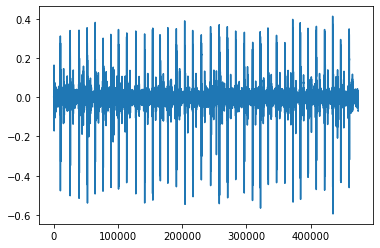

In [13]:
example_path = df_train["path"].iloc[10]
example_wav = load_wav_16k_mono(example_path)
print(example_wav.shape)
plt.plot(example_wav)
plt.show();

Getting the length of each audio file and add it to the df_train

In [14]:
# df_train["audio_length"] = df_train["path"].apply(lambda x: len(load_wav_16k_mono(x)))

In [15]:
# df_train["audio_length"].plot(kind = "hist");

In [16]:
# print("max: ", df_train["audio_length"].max())
# print("min: ", df_train["audio_length"].min())
# print("mean: ", df_train["audio_length"].mean())
# print("median: ", df_train["audio_length"].median())

# Creating some numerical data for Some Basic Models

In [70]:
le = LabelEncoder()
length_lr = 80000
delta = 4000
data = pd.DataFrame()
data["label"] = df_train["target"]
data["values"] = df_train["path"].apply(lambda x: 
                                        load_wav_16k_mono(x)[length_lr-delta:length_lr]\
                                        .numpy())

In [71]:
df_lr = pd.DataFrame(columns = list(range(0, delta)), 
                     index = data.index)
print("DONE!")

DONE!


In [72]:
for i in range(0,len(data)):
    df_lr.iloc[i] = pd.DataFrame(data["values"].iloc[i]).transpose()
    

df_lr["label"] = data["label"]    
print("DONE!")

DONE!


In [73]:
y = df_lr["label"]
X = df_lr.drop("label", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1, random_state=42,
                                                    shuffle=True, stratify=y)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print("DONE!")

DONE!


## Modeling

### Logistic Regression

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.25     0.79      0.79       0.52          0.68
      recall         0.01     0.99      0.79       0.50          0.79
      f1-score       0.03     0.88      0.79       0.45          0.70
      support       67.00   257.00      0.79     324.00        324.00
TRAIN precision      0.85     0.80      0.80       0.82          0.81
      recall         0.06     1.00      0.80       0.53          0.80
      f1-score       0.10     0.89      0.80       0.50          0.73
      support      598.00  2318.00      0.80    2916.00       2916.00

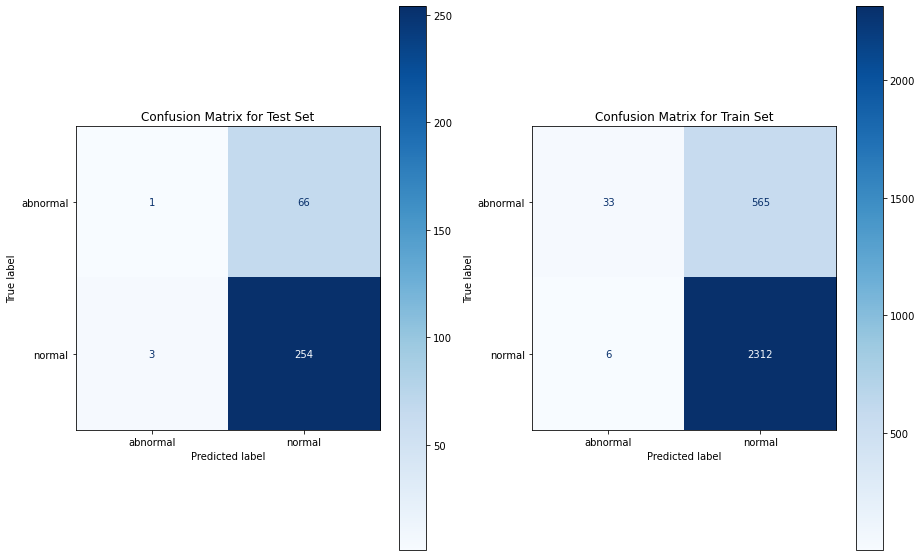

In [82]:
lr = LogisticRegression(solver='liblinear',random_state=42) #,class_weight="balanced")
lr.fit(X_train, y_train)
print("Fitting Done!")
print_results(lr, X_train, y_train,X_test, y_test)

### Decision Tree

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.35     0.84      0.72       0.59          0.73
      recall         0.39     0.81      0.72       0.60          0.72
      f1-score       0.37     0.82      0.72       0.59          0.73
      support       67.00   257.00      0.72     324.00        324.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support      598.00  2318.00      1.00    2916.00       2916.00

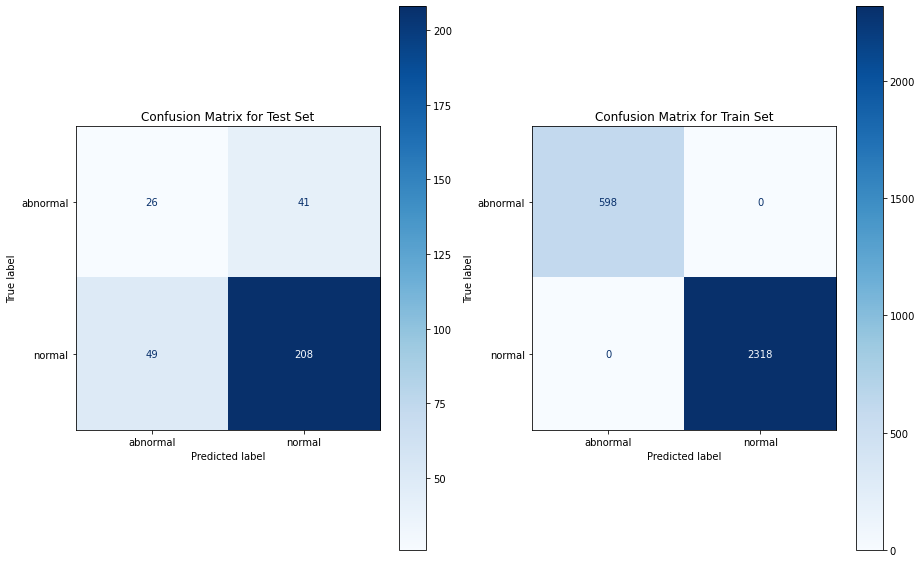

In [83]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Fitting Tree")
print_results(tree, X_train, y_train,X_test, y_test)

### Random Forest

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.47     0.82      0.79       0.64          0.75
      recall         0.21     0.94      0.79       0.57          0.79
      f1-score       0.29     0.87      0.79       0.58          0.75
      support       67.00   257.00      0.79     324.00        324.00
TRAIN precision      0.96     0.97      0.97       0.97          0.97
      recall         0.89     0.99      0.97       0.94          0.97
      f1-score       0.92     0.98      0.97       0.95          0.97
      support      598.00  2318.00      0.97    2916.00       2916.00

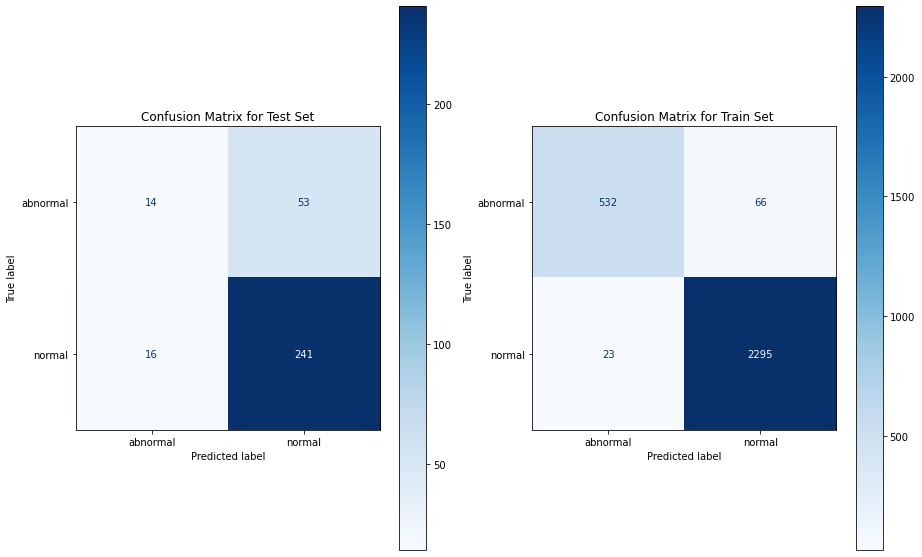

In [84]:
forest = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 5,
#                                 max_depth = 2, 
                                bootstrap = True, 
                                random_state = 42)

forest.fit(X_train, y_train)

print("Fitting Tree")
print_results(forest, X_train, y_train, X_test, y_test)

## Smote

In [80]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Logistic Regression SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.27     0.85      0.56       0.56          0.73
      recall         0.64     0.54      0.56       0.59          0.56
      f1-score       0.38     0.66      0.56       0.52          0.60
      support       67.00   257.00      0.56     324.00        324.00
TRAIN precision      0.65     0.73      0.68       0.69          0.69
      recall         0.79     0.58      0.68       0.68          0.68
      f1-score       0.71     0.64      0.68       0.68          0.68
      support     2318.00  2318.00      0.68    4636.00       4636.00

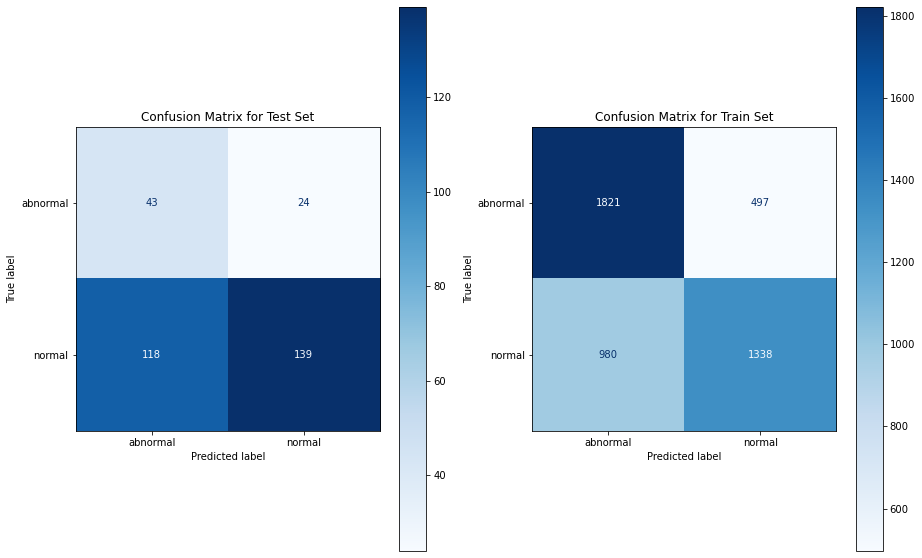

In [86]:
lr = LogisticRegression(solver='liblinear',random_state=42) #,class_weight="balanced")
lr.fit(X_train_smote, y_train_smote)
print("Fitting Done!")
print_results(lr, X_train_smote, y_train_smote, X_test, y_test)

### Decision Tree SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.29     0.83      0.67       0.56          0.72
      recall         0.42     0.73      0.67       0.57          0.67
      f1-score       0.34     0.78      0.67       0.56          0.69
      support       67.00   257.00      0.67     324.00        324.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support     2318.00  2318.00      1.00    4636.00       4636.00

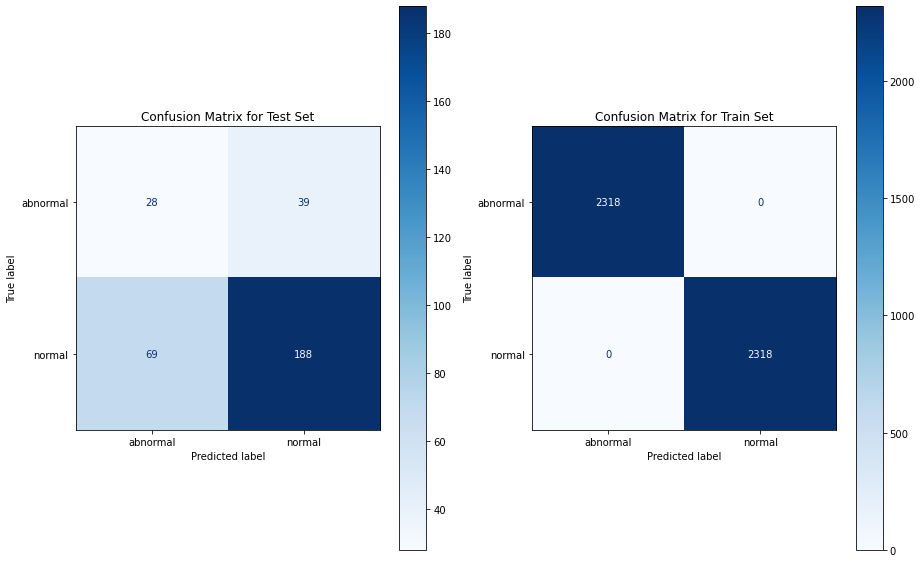

In [87]:
tree = DecisionTreeClassifier()
tree.fit(X_train_smote, y_train_smote)
print("Fitting Done!")
print_results(tree, X_train_smote, y_train_smote, X_test, y_test)

### Random Forest SMOTE

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.35     0.87      0.69       0.61          0.76
      recall         0.58     0.72      0.69       0.65          0.69
      f1-score       0.44     0.79      0.69       0.62          0.72
      support       67.00   257.00      0.69     324.00        324.00
TRAIN precision      0.80     0.84      0.82       0.82          0.82
      recall         0.84     0.79      0.82       0.82          0.82
      f1-score       0.82     0.81      0.82       0.82          0.82
      support     2318.00  2318.00      0.82    4636.00       4636.00

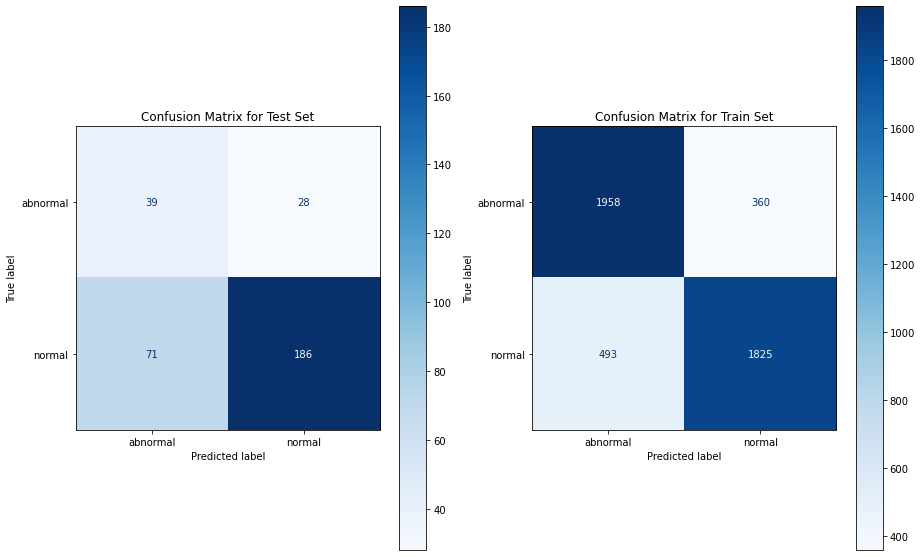

In [89]:
forest = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True, 
                                random_state = 42)

forest.fit(X_train_smote, y_train_smote)

print("Fitting Tree")
print_results(forest, X_train_smote, y_train_smote, X_test, y_test)

# Getting Spectrogram of the Audio Files 

In [44]:
df_train["name"].iloc[0]

'a0001'

In [57]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

### Example
audio_1 = df_train["name"].iloc[1000] 
audio_path = "../train_test_original/training-"+ audio_1[0] + "/"+ audio_1 + ".wav"
fig_path = "../spectrograms/"+  audio_1

SAMPLE_RATE = 3000
x, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(82044,) 3000


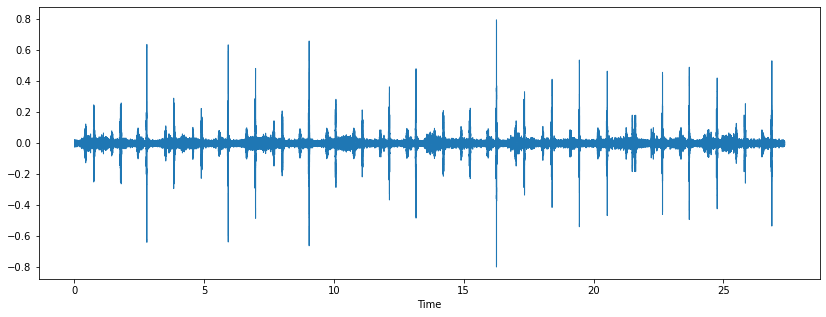

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

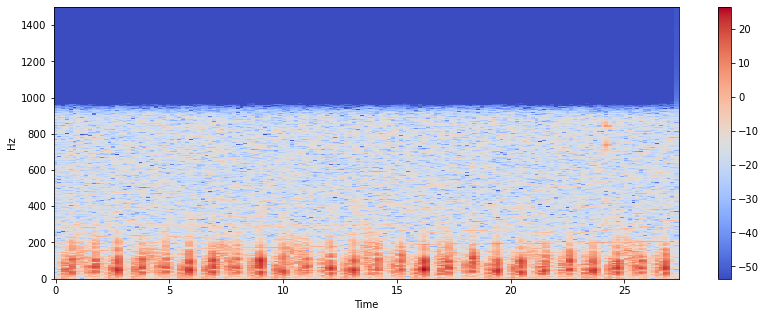

In [59]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
fig = plt.Figure()
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
fig.savefig(fig_path + '.png')

The following functions are from [here](https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349)

In [27]:
# def scale_minmax(X, min=0.0, max=1.0):
#     X_std = (X - X.min()) / (X.max() - X.min())
#     X_scaled = X_std * (max - min) + min
#     return X_scaled

# def spectrogram_image(y, sr, out, hop_length, n_mels):
#     # use log-melspectrogram
#     mels = librosa.feature.melspectrogram(y=y, sr=sr, 
#                                           n_mels=n_mels,
#                                           n_fft=hop_length*2, 
#                                           hop_length=hop_length)
    
#     mels = np.log(mels + 1e-9) # add small number to avoid log(0)

#     # min-max scale to fit inside 8-bit range
#     img = scale_minmax(mels, 0, 255).astype(np.uint8)
#     img = np.flip(img, axis=0) # put low frequencies at the bottom in image
#     img = 255-img # invert. make black==more energy

#     # save as PNG
#     skimage.io.imsave(out, img)

The next code is from [here](https://stackoverflow.com/questions/60255152/how-can-i-convert-spectrogram-data-to-a-tensor-or-multidimensional-numpy-array)

In [46]:
# import wave
# with wave.open(audio_file, "rb") as wave_file:
#     sr = wave_file.getframerate()
# print(sr)

# audio_binary = tf.read_file(audio_file)

# # tf.contrib.ffmpeg not supported on Windows, refer to issue
# # https://github.com/tensorflow/tensorflow/issues/8271
# waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format='wav', samples_per_second=sr, channel_count=1)
# print(waveform.numpy().shape)

# signals = tf.reshape(waveform, [1, -1])
# signals.get_shape()

# # Compute a [batch_size, ?, 128] tensor of fixed length, overlapping windows
# # where each window overlaps the previous by 75% (frame_length - frame_step
# # samples of overlap).
# frames = tf.contrib.signal.frame(signals, frame_length=128, frame_step=32)
# print(frames.numpy().shape)

# # `magnitude_spectrograms` is a [batch_size, ?, 129] tensor of spectrograms. We
# # would like to produce overlapping fixed-size spectrogram patches; for example,
# # for use in a situation where a fixed size input is needed.
# magnitude_spectrograms = tf.abs(tf.contrib.signal.stft(
#     signals, frame_length=256, frame_step=64, fft_length=256))

# print(magnitude_spectrograms.numpy().shape)